In [16]:
import matplotlib.pyplot as plt
import numpy as np
from pinocchio.visualize import MeshcatVisualizer
import time
import pinocchio

from scipy.interpolate import CubicSpline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import pandas as pd
import statistics as st
import tensorflow as tf
from keras.models import Sequential,load_model

from pyroboplan.core.utils import (
    get_random_collision_free_state,
    extract_cartesian_poses,
)

from pyroboplan.trajectory.polynomial import QuinticPolynomialTrajectory, CubicPolynomialTrajectory
from pyroboplan.trajectory.trapezoidal_velocity import TrapezoidalVelocityTrajectory
from pyroboplan.visualization.meshcat_utils import visualize_frames


In [17]:
filename = "../urdf/irb120.urdf"
model, collision_model, visual_model = pinocchio.buildModelsFromUrdf(filename)
data = model.createData()
collision_data = collision_model.createData()

q = pinocchio.randomConfiguration(model)
q.T[:] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
print(q)
pinocchio.forwardKinematics(model, data, q)

# Initialize visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model, data=data)
viz.initViewer(open=True)
viz.loadViewerModel()
viz.displayCollisions(False)
viz.displayVisuals(True)
viz.displayFrames(True)

[0. 0. 0. 0. 0. 0.]
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/vinoth/snap/code/common/.cache/gio-modules/libgiolibproxy.so


Opening in existing browser session.


# PYROBOPLAN

[-1.27660097 -0.6879749  -1.36024787 -1.63419925  2.03187845 -6.73934905]


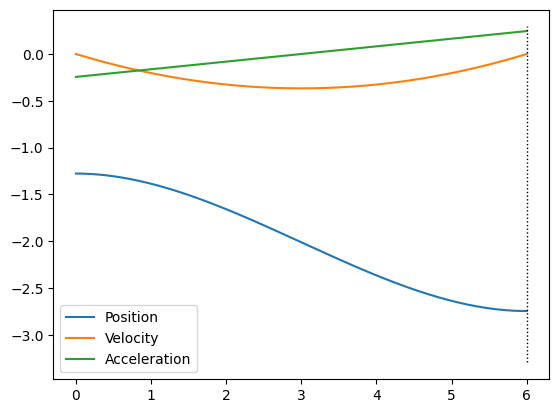

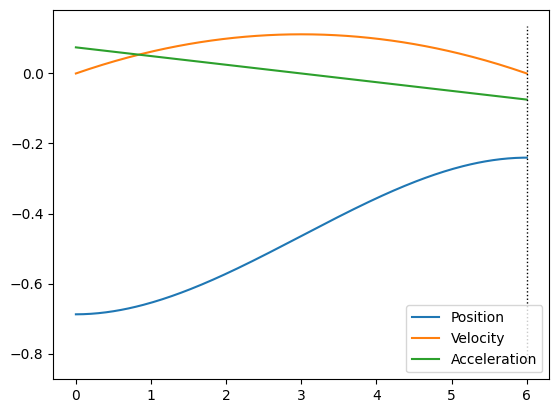

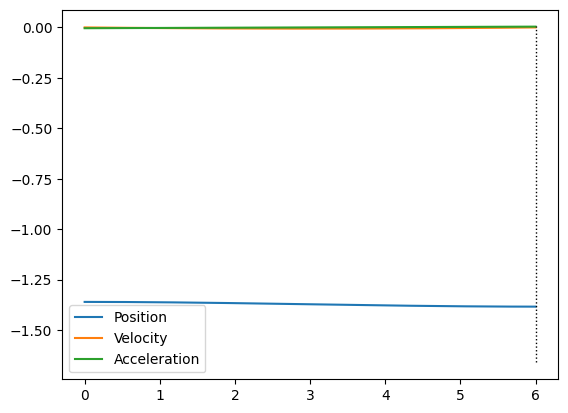

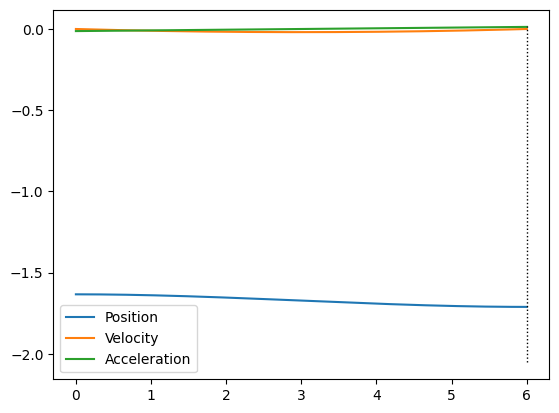

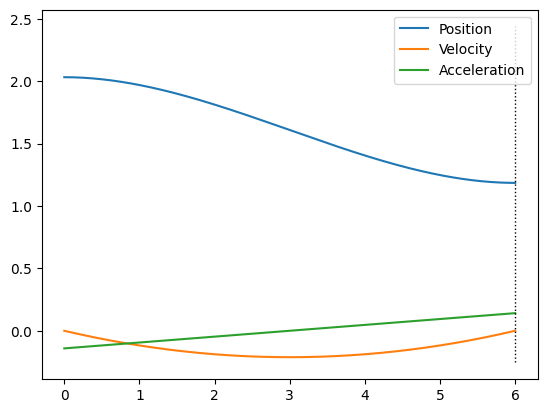

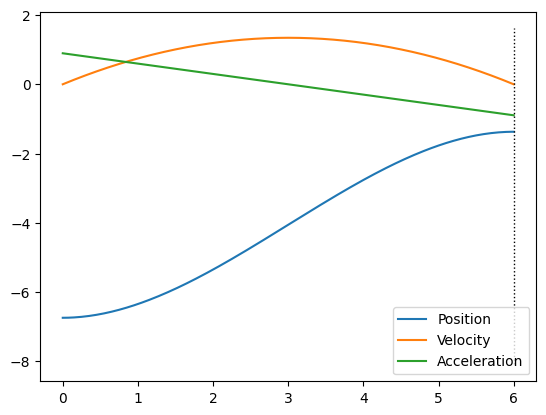

In [13]:
q_start = get_random_collision_free_state(model, collision_model)
q_end = get_random_collision_free_state(model, collision_model)
print(q_start)
q_mid = 0.5 * (q_start + q_end)
tool_transforms = []         # ADDED
tool_positions = []          # ADDED
# Generate a trajectory
dt = 0.025
# q = np.vstack([q_start, q_mid, q_end]).T
q = np.vstack([q_start, q_end]).T
mode = "cubic"
if mode == "trapezoidal":
    qd_max = 0.75
    qdd_max = 0.5
    traj = TrapezoidalVelocityTrajectory(q, qd_max, qdd_max)
    t_vec, q_vec, qd_vec, qdd_vec = traj.generate(dt)
elif mode == "quintic":
    t_vec = [0.0, 3.0, 6.0]
    qd = 0.0
    qdd = 0.0
    traj = QuinticPolynomialTrajectory(t_vec, q, qd, qdd)
    t_vec, q_vec, qd_vec, qdd_vec, qddd_vec = traj.generate(dt)
elif mode == "cubic":
    # t_vec = [0.0, 3.0, 6.0]
    t_vec = [0.0, 6.0]
    qd = 0.0
    traj = CubicPolynomialTrajectory(t_vec, q, qd)
    t_vec, q_vec, qd_vec, qdd_vec,qddd_vec  = traj.generate(dt)
    

# Display the trajectory and points along the path.
# If using a polynomial trajectory, you can also add show_jerk=True.
plt.ion()
traj.visualize(
    dt=dt,
    joint_names=model.names[1:],
    show_position=True,
    show_velocity=True,
    show_acceleration=True,
)
time.sleep(0.5)

tforms = extract_cartesian_poses(model, "tool0", [q_start,q_end])
viz.display(q_start)
visualize_frames(viz, "waypoints", tforms)
time.sleep(0.5)

# Animate the generated trajectory
input("Press 'Enter' to animate the path.")
for idx in range(q_vec.shape[1]):
    viz.display(q_vec[:, idx])
    tool_transform = extract_cartesian_poses(model, "tool0", [q_vec[:, idx]])
    tool_transforms.append(tool_transform[0])
    time.sleep(dt)

tool_positions = np.array(tool_positions)
#visualize_frames(viz, "trajectory_tool_positions", tool_transforms)

plt.show()


In [10]:
CubicSpline?

Init signature: CubicSpline(x, y, axis=0, bc_type='not-a-knot', extrapolate=None)
Docstring:     
Cubic spline data interpolator.

Interpolate data with a piecewise cubic polynomial which is twice
continuously differentiable [1]_. The result is represented as a `PPoly`
instance with breakpoints matching the given data.

Parameters
----------
x : array_like, shape (n,)
    1-D array containing values of the independent variable.
    Values must be real, finite and in strictly increasing order.
y : array_like
    Array containing values of the dependent variable. It can have
    arbitrary number of dimensions, but the length along ``axis``
    (see below) must match the length of ``x``. Values must be finite.
axis : int, optional
    Axis along which `y` is assumed to be varying. Meaning that for
    ``x[i]`` the corresponding values are ``np.take(y, i, axis=axis)``.
    Default is 0.
bc_type : string or 2-tuple, optional
    Boundary condition type. Two additional equations, given by th

# NEURAL NETWORK

In [32]:
predmodel = load_model('../models/finalmodelfull1000.h5')

# x1,y1,z1 = map(float, input('Enter coordinates of Point 1: ').split())
# x2,y2,z2 = map(float, input('Enter coordinates of Point 2: ').split())
# x3,y3,z3 = map(float, input('Enter coordinates of Point 3: ').split())

point_A = np.array([0.15, -0.4, 0.2])  # Starting point (x1, y1, z1)
point_B = np.array([0.25, 0.0, 0.5])  # Intermediate point (x2, y2, z2)
point_C = np.array([0.15, 0.4, 0.2]) # Ending point (x3, y3, z3)


A = np.hstack((point_A + np.array([0,0,0])))
C = np.hstack((point_C + np.array([0,0,0])))
# Create an array for the parameter t (e.g., time or position)
t = np.array([0, 0.5, 1])  # 0 corresponds to Point A, 0.5 to Point B, 1 to Point C

# Interpolate for x, y, and z separately using cubic splines
cs_x = CubicSpline(t, [point_A[0], point_B[0], point_C[0]])
cs_y = CubicSpline(t, [point_A[1], point_B[1], point_C[1]])
cs_z = CubicSpline(t, [point_A[2], point_B[2], point_C[2]])

# Generate intermediate points along the spline (e.g., 100 points)
t_fine = np.linspace(0, 1, 1000)
x_spline = cs_x(t_fine)
y_spline = cs_y(t_fine)
z_spline = cs_z(t_fine)

# Combine x, y, and z into a single array of waypoints
waypoints = np.vstack((x_spline, y_spline, z_spline)).T

# Print the waypoints
print("Spline Interpolated Waypoints:")
print(waypoints)


Spline Interpolated Waypoints:
[[ 0.15       -0.4         0.2       ]
 [ 0.1504     -0.3991992   0.2012    ]
 [ 0.1507992  -0.3983984   0.20239759]
 ...
 [ 0.1507992   0.3983984   0.20239759]
 [ 0.1504      0.3991992   0.2012    ]
 [ 0.15        0.4         0.2       ]]


In [5]:
len(waypoints)

1000

In [6]:
waypoints[1]

array([ 0.1504   , -0.3991992,  0.2012   ])

In [4]:
jvals = predmodel.predict([waypoints])
qval = jvals[1]

32/32 [==============================] - 0s 742us/step


In [8]:
qval.shape

(6,)

In [22]:
start = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
pinocchio.framesForwardKinematics(model, data, start)
viz.display(start)

tf = extract_cartesian_poses(model, "tool0", [A,C])
visualize_frames(viz, "waypoints", tf)
for i in range(len(jvals)):
    # qnext = pinocchio.randomConfiguration(model)
    # qnext.T[:] = jvals[i]
    qnext = jvals[i]
    pinocchio.framesForwardKinematics(model, data, qnext)
    viz.display(qnext)

ValueError: wrong argument size: expected 6, got 3
hint: The configuration vector is not of right size
